# Logistic Regression from Scratch

In [3]:
import numpy as np
import matplotlib.pyplot as plt

BERNOULLI DISTRIBUTION

OPTIMIZATION/FITTING

LOSS FUNCTION

BINARY CROSS ENTROPY LOSS FUNCTION

DERIVATIVE OF LOSS FUNCTION

GRADIENT DESCENT


$$ \hat{y} = \frac{1}{1+e^{-(b+wx)}} $$

$$ p(\hat{y}, y)=\begin{cases}
    \hat{y} & y=1 \\
    1-\hat{y} & y=0
    \end{cases}
$$

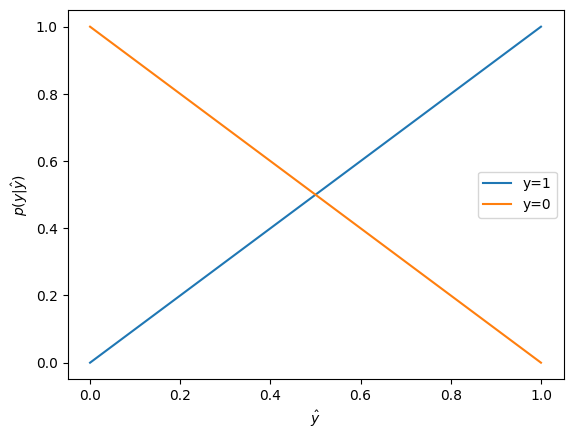

In [4]:
def bernoulli_dist(y, y_hat):
    return y_hat**y * (1-y_hat)**(1-y)

y_hat = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(y_hat, bernoulli_dist(1, y_hat), label='y=1')
ax.plot(y_hat, bernoulli_dist(0, y_hat), label='y=0')
ax.set_xlabel(r'$\hat{y}$')
ax.set_ylabel(r'$p(y|\hat{y})$')
ax.legend()
plt.show()

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/2771818357.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x), label='log(x)')


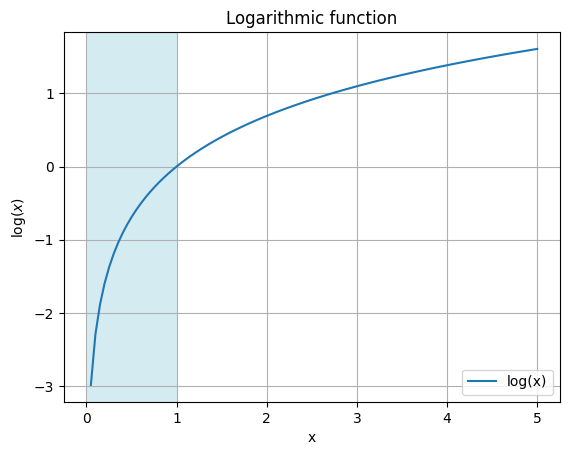

In [16]:
x = np.linspace(0, 5, 100)

plt.plot(x, np.log(x), label='log(x)')
plt.xlabel('x')
plt.ylabel('$\log(x)$')
plt.title('Logarithmic function')
plt.grid()
plt.axvspan(0, 1, facecolor='lightblue', alpha=0.5)
plt.legend()


1. $\log(xy) = \log(x) + \log(y)$
2. $\log\left(\frac{x}{y}\right) = \log(x) - \log(y)$
3. $\log(x^n) = n\log(x)$
4. $\log(1) = 0$
5. $\log(0) = -\inf$

$$ \log(p(y|x))=y\log(\hat{y})+(1-y)\log(1-\hat{y})$$

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/854167381.py:2: RuntimeWarning: divide by zero encountered in log
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/854167381.py:2: RuntimeWarning: invalid value encountered in multiply
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


Text(0.5, 1.0, 'Log Loss')

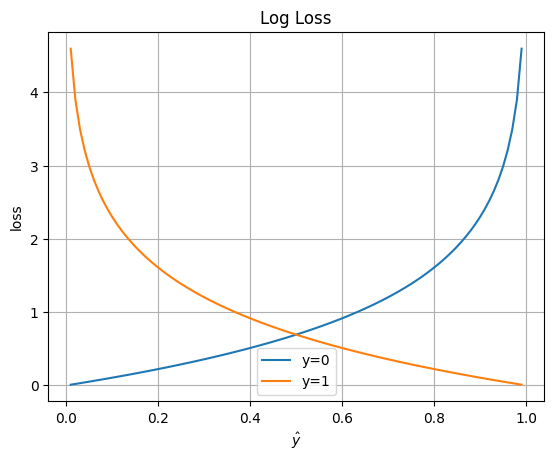

In [19]:
def loss_log(y, y_hat):
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))

x = np.linspace(0, 1, 100)

plt.plot(x, loss_log(0, x), label='y=0')
plt.plot(x, loss_log(1, x), label='y=1')
plt.legend()
plt.grid()
plt.xlabel('$\hat{y}$')
plt.ylabel('loss')
plt.title('Log Loss')


$$ \begin{align}
    \notag \frac{\partial{L}}{\partial{w}}&=\frac{\partial}{\partial{w}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))\\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}1-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))\frac{\partial}{\partial{w}}(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))x \\
    \notag &=-(y-\sigma(wx+b))x \\
    \notag &= (\sigma(wx+b)-y)x \\
\end{align}
$$

$$ \begin{align}
    \notag \textcolor{lightgray}{\frac{\partial{L}}{\partial{b}}}&\textcolor{gray}{=\frac{\partial}{\partial{b}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))}\\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}1-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{glightray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))}\frac{\partial}{\partial{b}}(wx+b) \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))} \cdot 1 \\
    \notag &=-(y-\sigma(wx+b)) \\
    \notag &= \sigma(wx+b)-y \\
\end{align}
$$

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/3150900135.py:2: RuntimeWarning: divide by zero encountered in log
  return y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/3150900135.py:2: RuntimeWarning: invalid value encountered in multiply
  return y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)


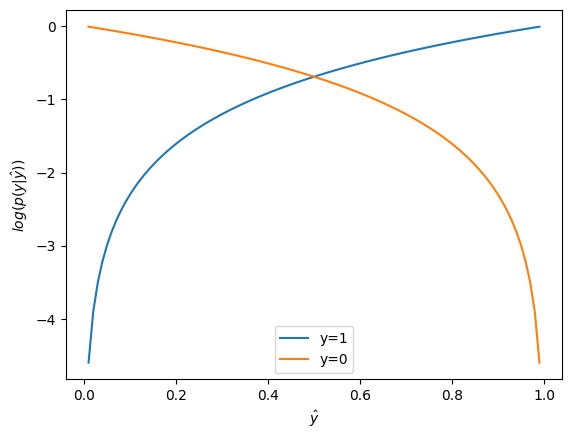

In [7]:
def log_bernoulli_dist(y, y_hat):
    return y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)

y_hat = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(y_hat, log_bernoulli_dist(1, y_hat), label='y=1')
ax.plot(y_hat, log_bernoulli_dist(0, y_hat), label='y=0')
ax.set_xlabel(r'$\hat{y}$')
ax.set_ylabel(r'$log(p(y|\hat{y}))$')
ax.legend()
plt.show()